In [1]:
#%pip install pandas
import pandas as pd
import re
import string
import json

In [2]:
df = pd.read_csv("data_huang_devansh.csv", encoding='utf8')
df["Content"] = df["Content"].astype(str)

In [3]:
HTTP_PATTERN = re.compile(".*http.*")
def remove_links(txt):
    # Split the string into words
    words = txt.split()
    
    # Use regular expression to find words containing "http"
    http_words = [word for word in words if HTTP_PATTERN.match(word)]
    count = len(http_words)
    
    for word in http_words:
        words.remove(word)
    
    txt = ' '.join(words).replace("</a>","").replace("<a","").replace("</a", "")
    
    # Join the remaining words back into a string
    return txt,count

df["Content"],df["Links"] = zip(*df["Content"].apply(remove_links))

In [4]:
df["Length"]=df["Content"].apply(lambda txt: len(txt))

In [5]:
df["Upper_case"]=df["Content"].apply(lambda txt: sum(1 for c in txt if c.isupper()))

In [6]:
df["Hashtag"] = df["Content"].apply(lambda txt: sum(1 for word in txt.split() if word.startswith("#")))

In [7]:
df["User_mentions"] = df["Content"].apply(lambda txt: sum(1 for word in txt.split() if word.startswith('@')))

In [8]:
df["Digits"] = df["Content"].apply(lambda txt: sum(1 for c in txt if c.isdigit()))

In [9]:
def count_special_chars(txt):
    special_chars = [char for char in txt if char in string.punctuation]
    return len(special_chars)

df["Special_char"]=df["Content"].apply(count_special_chars)

In [10]:
#Remove special chars from the string (except quotation marks)
def remove_trailing_chars(txt):
    new_str = []
    for x in txt.split():
        new_str.append(str(x).lstrip('_\-;%()|+&=*%.@#,!?:$[]/^`~<>\'"').rstrip('"_\-;%()|+&=*%.,!?:#$@[]/^~`<>\'"')
                       .replace("\\n"," ").replace("\\\\xa0"," ").replace("\\r"," ").replace("\\'","'")
                       .replace("\\\\xc2"," ").replace("\\xa0"," ").replace("\\xc2"," ").replace("\\",""))
        
    return ' '.join(new_str)

In [11]:
with open("Contractions.json",'r')as f:
        contractions = json.load(f)

df["Content"] = df["Content"].apply(remove_trailing_chars)

In [12]:
def replace_contractions(txt):
    txt = txt.split()
    new_string = [contractions.get(word.lower(),word) for word in txt]
    return ' '.join(new_string)

In [13]:
df["Content"] = df["Content"].apply(replace_contractions)

In [14]:
def clear_text(input_string):
    # Create a translation table with all special characters and digits mapped to None
    translation_table = str.maketrans('', '', string.punctuation + string.digits)
    
    # Split the input string into words and remove special characters and digits from each word
    words = [word.translate(translation_table) for word in input_string.split()]
    
    # Join the cleaned words back into a string
    cleaned_string = ' '.join(words).lower()
    return cleaned_string


df['Content'] = df['Content'].apply(clear_text)

In [15]:
from sklearn.feature_extraction.text import CountVectorizer

# Read the CSV file into a dataframe and extract the words into a set
profanities_df = pd.read_csv('Profanities.csv', header=None, names=['word'])
profanities = set(profanities_df['word'])

def count_profanities(txt):
    global profanities
    vectorizer = CountVectorizer(vocabulary=profanities, ngram_range=(1, len(max(profanities, key=len))))
    counts = vectorizer.transform([txt])
    return counts.sum()

df["Profanities"] = df["Content"].apply(count_profanities)

In [16]:
#%pip install nltk
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

# Get stopwords for English
stop = stopwords.words('english')

df['Content'] = df['Content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
import nltk
nltk.download('wordnet')  # Download WordNet corpus for lemmatisation
nltk.download("punkt")
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

# Initialize the lemmatiser
lemmatizer = WordNetLemmatizer()

df['Content'] = df['Content'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\filip\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [18]:
df.describe()

,Label,Links,Length,Upper_case,Hashtag,User_mentions,Digits,Special_char,Profanities
count,842335.000000,842335.000000,842335.000000,842335.000000,842335.000000,842335.000000,842335.000000,842335.000000,842335.000000
mean,0.158718,0.053225,297.714794,13.821526,0.282700,0.200281,2.037591,13.340046,0.646633
std,0.365413,0.420897,558.863353,117.404282,1.265872,0.982710,14.596579,44.949700,11.436330
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,68.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,0.000000,0.000000,129.000000,5.000000,0.000000,0.000000,0.000000,7.000000,0.000000
75%,0.000000,0.000000,297.000000,11.000000,0.000000,0.000000,0.000000,13.000000,0.000000
max,1.000000,85.000000,19906.000000,10501.000000,380.000000,50.000000,4246.000000,9946.000000,2000.000000


In [19]:
df.to_csv("preprocessed_data.csv", index=False)

In [2]:
df = pd.read_csv("preprocessed_data.csv", encoding='utf8')
df["Content"] = df["Content"].astype(str)
df.describe()

,Label,Links,Length,Upper_case,Hashtag,User_mentions,Digits,Special_char,Profanities
count,842335.000000,842335.000000,842335.000000,842335.000000,842335.000000,842335.000000,842335.000000,842335.000000,842335.000000
mean,0.158718,0.053225,297.714794,13.821526,0.282700,0.200281,2.037591,13.340046,0.646633
std,0.365413,0.420897,558.863353,117.404282,1.265872,0.982710,14.596579,44.949700,11.436330
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,68.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,0.000000,0.000000,129.000000,5.000000,0.000000,0.000000,0.000000,7.000000,0.000000
75%,0.000000,0.000000,297.000000,11.000000,0.000000,0.000000,0.000000,13.000000,0.000000
max,1.000000,85.000000,19906.000000,10501.000000,380.000000,50.000000,4246.000000,9946.000000,2000.000000


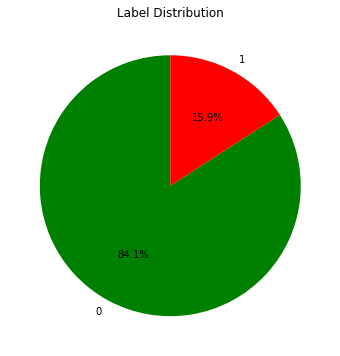

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

def label_distribution(data):
    
    label_counts = np.bincount(data)
    labels = np.unique(data)
    colors = ['green', 'red']

    plt.figure(figsize=(6, 6))
    plt.pie(label_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    plt.title('Label Distribution')
    plt.show()

label_distribution(df["Label"])


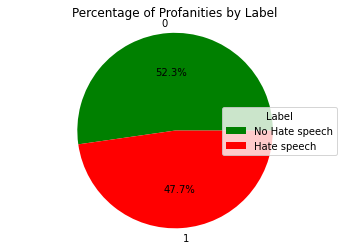

In [5]:
# Group the dataframe by 'Label' and calculate the sum of 'Profanities' for each label
profanity_totals = df.groupby('Label')['Profanities'].sum()

# Set custom colors for the pie chart
colors = ['green', 'red']

# Create a pie chart
plt.pie(profanity_totals, labels=profanity_totals.index, autopct='%1.1f%%', colors=colors)

# Add a legend on the right side
plt.legend(title='Label', labels=['No Hate speech', 'Hate speech'], loc='center right')

plt.title("Percentage of Profanities by Label")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


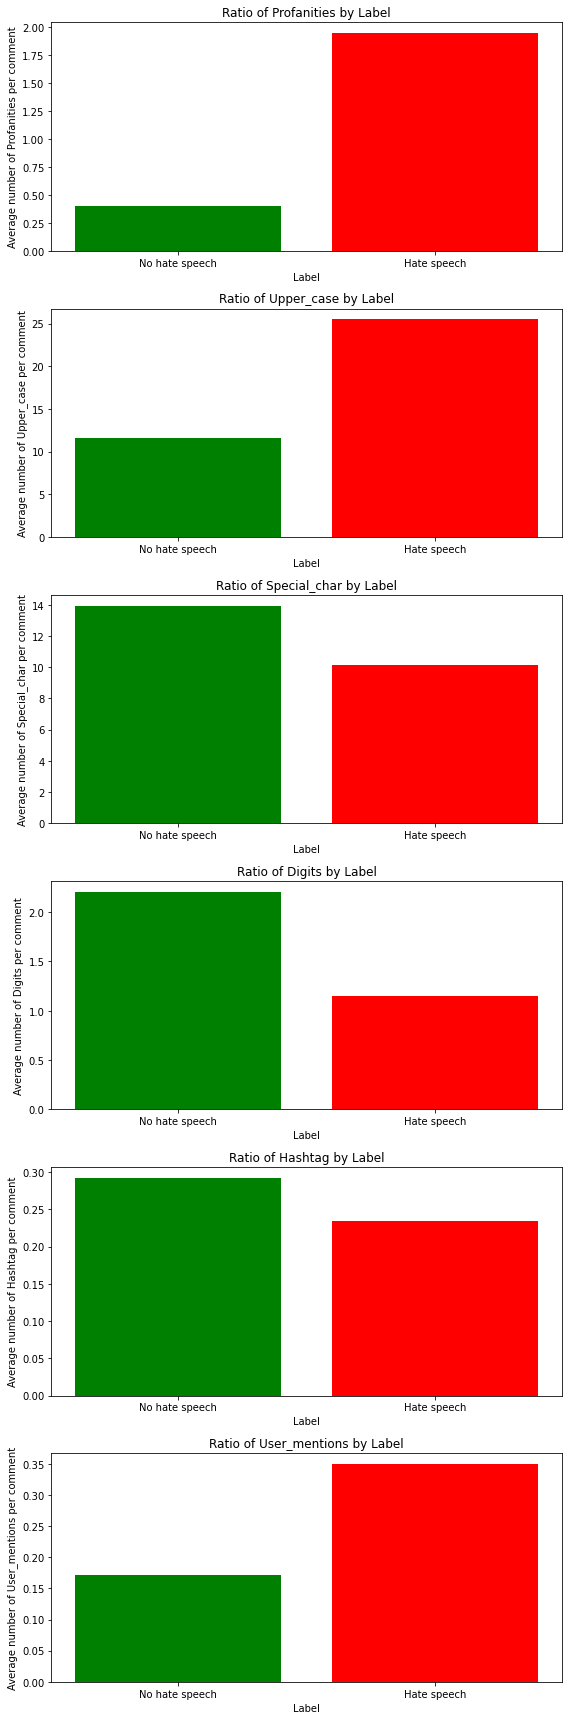

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def ratio(attribute):
    # Calculate ratios
    total_counts = df['Label'].value_counts()  # Count the occurrences of each label (0 and 1)
    profanities_0 = df.loc[df['Label'] == 0, attribute]  # Profanities for label 0
    profanities_1 = df.loc[df['Label'] == 1, attribute]  # Profanities for label 1
    ratio_0 = np.sum(profanities_0) / total_counts[0]  # Ratio of profanities for label 0
    ratio_1 = np.sum(profanities_1) / total_counts[1]  # Ratio of profanities for label 1

    return [ratio_0, ratio_1]

# Plotting the stacked bar charts
categories = ['No hate speech', 'Hate speech']
colors = ['green', 'red']

attributes = ["Profanities", "Upper_case", "Special_char", "Digits", "Hashtag", "User_mentions"]
ratios = [ratio(attr) for attr in attributes]

fig, axs = plt.subplots(len(attributes), 1, figsize=(8, len(attributes) * 4))

for i in range(len(attributes)):
    axs[i].bar(categories, ratios[i], color=colors)
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Average number of ' + attributes[i] + ' per comment')
    axs[i].set_title('Ratio of ' + attributes[i] + ' by Label')

plt.tight_layout()
plt.show()


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def histogram_profanities(dataframe, profanities, color):
    # Create a CountVectorizer with a custom vocabulary of profanities
    vectorizer = CountVectorizer(vocabulary=profanities, ngram_range=(1, len(max(profanities, key=len))))

    # Transform the dataframe column into a bag-of-words matrix
    bow_matrix = vectorizer.fit_transform(dataframe)

    # Get the vocabulary (profanities)
    vocabulary = vectorizer.get_feature_names_out()

    # Calculate the frequency of each profanity
    profanity_frequencies = bow_matrix.sum(axis=0).A1

    # Sort profanities and frequencies in descending order
    sorted_indices = np.argsort(profanity_frequencies)[::-1]
    sorted_profanities = [vocabulary[i] for i in sorted_indices]
    sorted_frequencies = profanity_frequencies[sorted_indices]

    # Plot the histogram
    plt.bar(sorted_profanities[:10], sorted_frequencies[:10], color=color)
    plt.xlabel('Profanities')
    plt.ylabel('Frequency')
    plt.title('Top 10 Most Frequent Profanities')
    plt.xticks(rotation=45)
    plt.show()


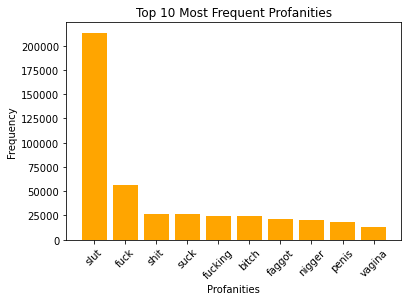

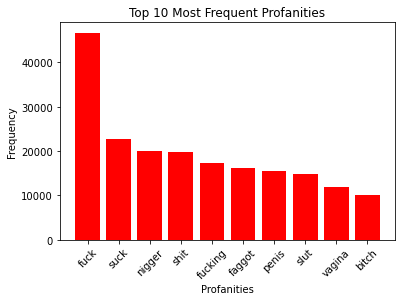

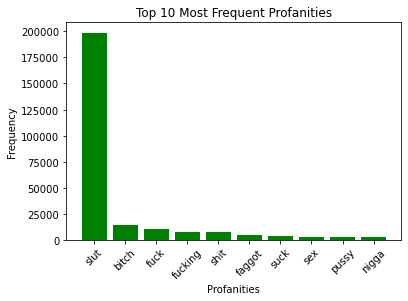

In [8]:
#profanities_df = pd.read_csv('Profanities.csv', header=None, names=['word'])
#profanities = set(profanities_df['word'])

histogram_profanities(df["Content"],list(profanities),"orange")
#Hate speech subset graph
histogram_profanities(df[df["Label"]==1]["Content"],list(profanities),"red")
#NON hate speech subset graph
histogram_profanities(df[df["Label"]==0]["Content"],list(profanities),"green")

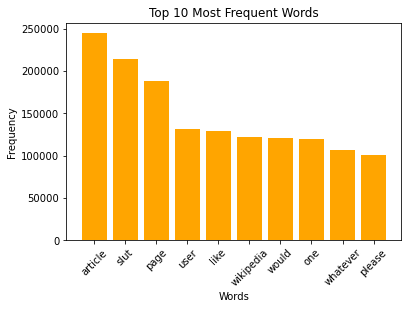

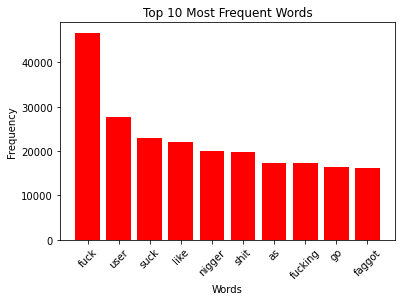

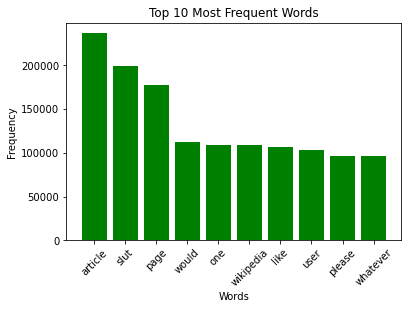

In [9]:
from collections import Counter

def histogram_words(dataframe, color):
    
    words = dataframe.str.split()  # Split text by spaces to get individual words

    # Flatten the list of words
    word_list = [word for sublist in words for word in sublist]

    # Count the frequency of each word using Counter
    word_counts = Counter(word_list)

    # Get the top 10 most frequent words and their counts
    top_words = word_counts.most_common(10)
    words, counts = zip(*top_words)

    # Plot the histogram
    plt.bar(words, counts, color=color)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title('Top 10 Most Frequent Words')
    plt.xticks(rotation=45)
    plt.show()

histogram_words(df["Content"],"orange")
histogram_words(df[df["Label"]==1]["Content"],"red")
histogram_words(df[df["Label"]==0]["Content"],"green")


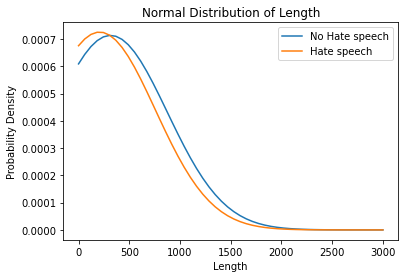

In [10]:
from scipy.stats import norm

# Filter the DataFrame by Label values
label_0_lengths = df[df["Label"] == 0]["Length"]
label_1_lengths = df[df["Label"] == 1]["Length"]

# Fit a normal distribution to the length values
mean_0, std_0 = norm.fit(label_0_lengths)
mean_1 , std_1 = norm.fit(label_1_lengths)
# Generate x-values for the plot
x_0 = np.linspace(label_0_lengths.min(), 3000)
x_1 = np.linspace(label_1_lengths.min(), 3000)
# Calculate the corresponding y-values using the fitted distribution
y_0 = norm.pdf(x_0, mean_0, std_0)
y_1 = norm.pdf(x_1, mean_1, std_1)
# Plot the normal distribution
plt.plot(x_0, y_0, label="No Hate speech")
plt.plot(x_1, y_1, label="Hate speech")
plt.xlabel("Length")
plt.ylabel("Probability Density")
plt.title("Normal Distribution of Length")
plt.legend()
plt.show()


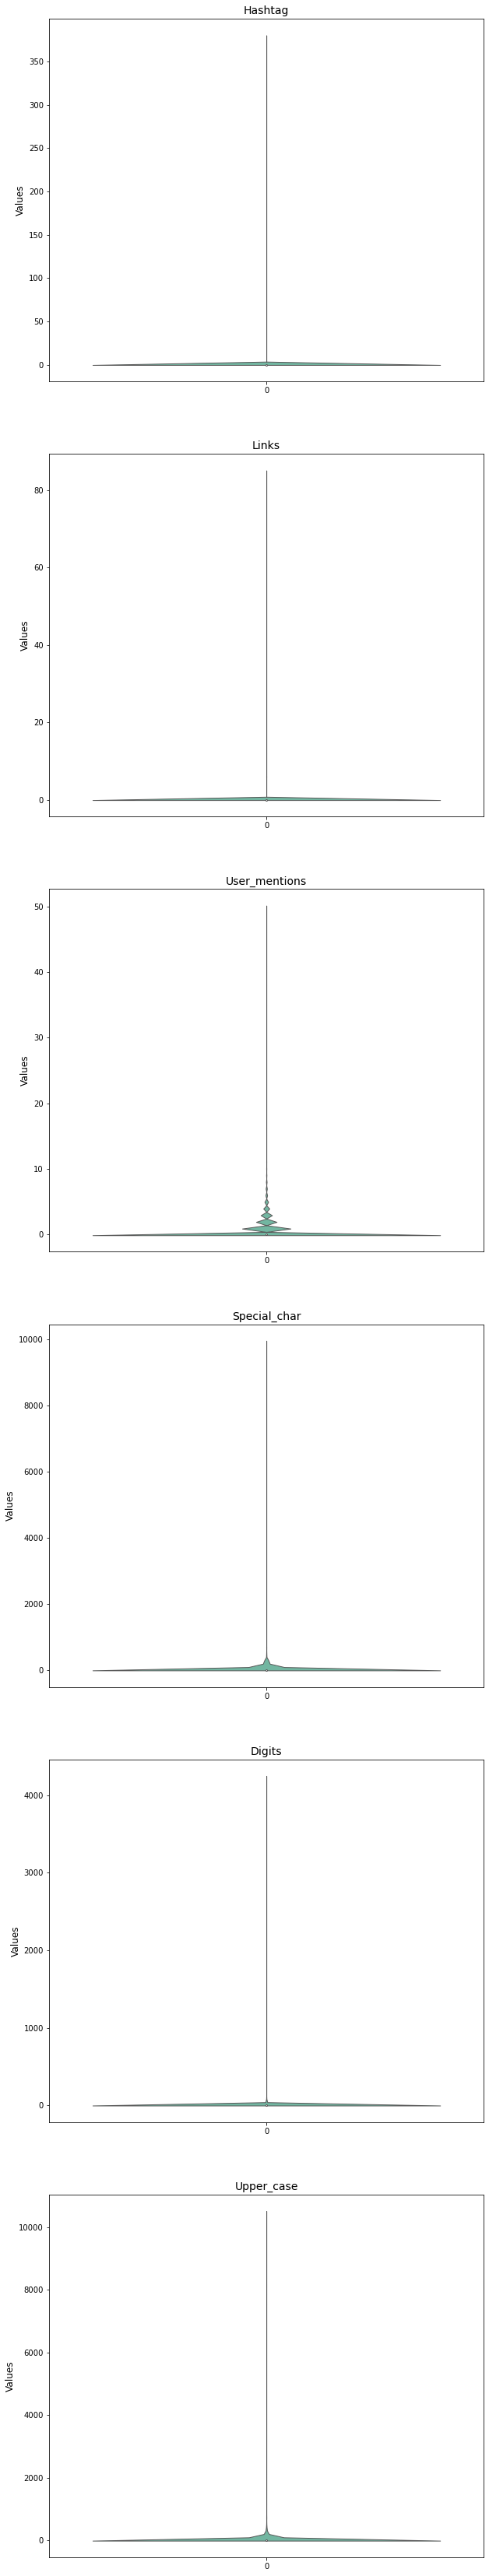

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the attributes
attributes = ["Hashtag", "Links", "User_mentions", "Special_char", "Digits", "Upper_case"]
num_attributes = len(attributes)

# Set the figure size
plt.figure(figsize=(10, 10 * num_attributes))

# Create subplots for each attribute
for i, attribute in enumerate(attributes):
    plt.subplot(num_attributes, 1, i+1)
    
    # Create the violin plot for the current attribute
    sns.violinplot(data=df[attribute], palette="Set2", scale="width", linewidth=1)
    
    # Set the y-axis label
    plt.ylabel("Values", fontsize=12)
    
    # Set the title for the subplot
    plt.title(attribute, fontsize=14)
    
# Show the plot
plt.show()


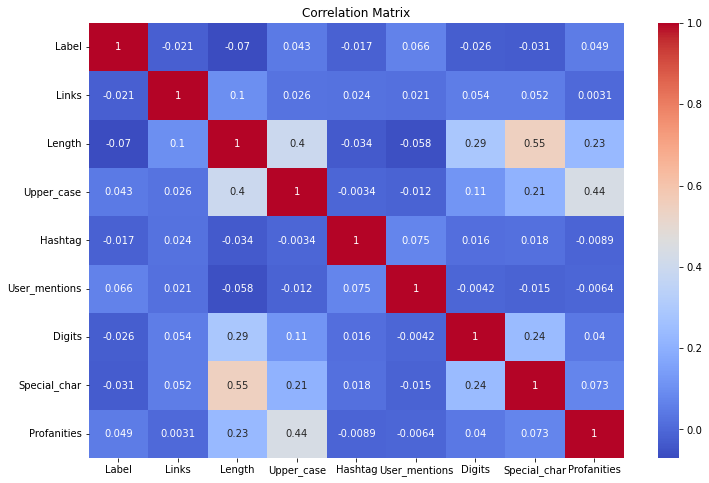

In [12]:
correlation_matrix = df.drop("Content",axis=1).corr()

plt.figure(figsize=(12, 8))
# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


1) Split the dataset
2) Remove outliers -> only on the training set
3) Normalize -> both sets
4) TF-IDF -> both sets
6) Balancing the training set (SMOTE) -> only training set
5) Features selection (RFE) -> both sets

In [3]:
#1)
from sklearn.model_selection import train_test_split

# Split the dataset into features (X) and labels (y)
X = df.drop("Label", axis=1)
Y = df['Label']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [4]:
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split

# Define a function to remove outliers using Z-score
def remove_outliers_Zscore(attribute, X_train, Y_train):
    # Calculate modified z-scores
    z_scores = np.abs(stats.zscore(X_train[attribute], ddof=0.6745))

    # Set threshold for outliers
    threshold = 3.5

    # Identify outliers
    outliers_indices = np.where(z_scores > threshold)[0]
    print("Outliers for attribute " + attribute + " -> " + str(len(outliers_indices)))

    # Create a boolean mask to filter out outliers
    mask = np.ones(len(X_train), dtype=bool)
    mask[outliers_indices] = False

    # Filter out outliers from X_train and Y_train
    X_train_cleaned = X_train[mask]
    Y_train_cleaned = Y_train[mask]

    return X_train_cleaned, Y_train_cleaned

# List of attributes
attributes = ["Length", "Links", "Upper_case", "Profanities", "Hashtag", "User_mentions", "Special_char", "Digits"]

# Filter outliers for each attribute
for attribute in attributes:
    X_train, y_train = remove_outliers_Zscore(attribute, X_train, y_train)

# Display summary statistics
X_train.describe()


Outliers for attribute Length -> 9750
Outliers for attribute Links -> 3428
Outliers for attribute Upper_case -> 4049
Outliers for attribute Profanities -> 5472
Outliers for attribute Hashtag -> 11532
Outliers for attribute User_mentions -> 4789
Outliers for attribute Special_char -> 7350
Outliers for attribute Digits -> 3873


,Links,Length,Upper_case,Hashtag,User_mentions,Digits,Special_char,Profanities
count,623625.000000,623625.000000,623625.000000,623625.000000,623625.000000,623625.000000,623625.000000,623625.000000
mean,0.031238,223.411068,7.678991,0.158667,0.152773,1.143225,9.505615,0.336014
std,0.173961,266.339988,10.301552,0.589869,0.480996,2.918658,10.256237,0.714545
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,65.000000,1.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,0.000000,124.000000,4.000000,0.000000,0.000000,0.000000,6.000000,0.000000
75%,0.000000,271.000000,10.000000,0.000000,0.000000,0.000000,12.000000,0.000000
max,1.000000,2241.000000,100.000000,4.000000,3.000000,21.000000,63.000000,4.000000


In [5]:
#3)
from sklearn.preprocessing import RobustScaler

# Select the columns to be scaled
columns_to_scale = ["Length", "Links", "Upper_case", "Profanities", "Hashtag", "User_mentions", "Special_char", "Digits"]

# Create a RobustScaler object
scaler = RobustScaler()

# Fit the scaler on the selected columns
scaler.fit(X_train[columns_to_scale])

# Transform the selected columns
X_train[columns_to_scale] = scaler.transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.transform(X_test[columns_to_scale])

In [6]:
#4)
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.combine import SMOTEENN
from scipy import sparse

# Preprocess text data
# Example: Tokenization and TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=300)
X_train_tfidf = pd.DataFrame.sparse.from_spmatrix(vectorizer.fit_transform(X_train['Content']))

# Transform the test data
X_test_tfidf = pd.DataFrame.sparse.from_spmatrix(vectorizer.transform(X_test['Content']))

# Drop the 'Content' column from X_train and X_test
X_train = X_train.drop('Content', axis=1)
X_test = X_test.drop('Content', axis=1)

X_train.reset_index(drop=True,inplace=True)
X_train_tfidf.reset_index(drop=True,inplace=True)
X_train = pd.concat([X_train,X_train_tfidf],axis=1)

X_test.reset_index(drop=True,inplace=True)
X_test_tfidf.reset_index(drop=True,inplace=True)
X_test = pd.concat([X_test,X_test_tfidf],axis=1)

X_test.columns = X_test.columns.astype(str)
X_train.columns = X_train.columns.astype(str)


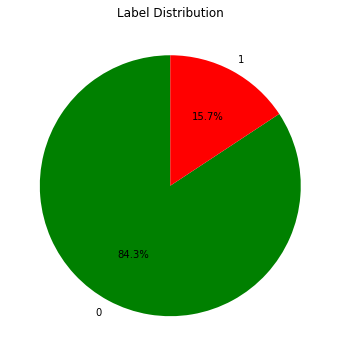

In [9]:
label_distribution(y_train)

In [11]:
import numpy as np
from imblearn.combine import SMOTEENN

# Create an instance of SMOTEENN
smoteenn = SMOTEENN(random_state=42)

X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)


c:\Users\filip\anaconda3\lib\site-packages\sklearn\utils\validation.py:624: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [ ]:
X_train_resampled.to_csv("X_train_resampled.csv", index=False)
y_train_resampled.to_csv("y_train_resampled.csv", index=False)

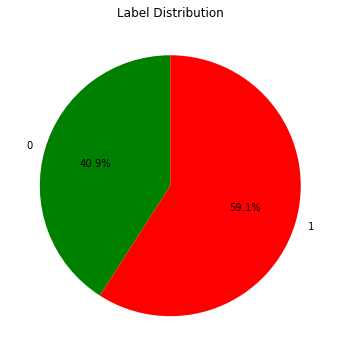

Number of features in X_train_balanced: 626428


In [ ]:
label_distribution(y_train_resampled)

n_features = X_train.shape[0]
print("Number of features in X_train_balanced:", n_features)

In [ ]:
X_train_resampled = pd.read_csv("X_train_resampled.csv")

y_train_resampled = pd.read_csv("y_train_resampled.csv")


-Feature Selection: SelectKBest + Classification:

    Feature Selection: SelectKBest with a suitable scoring function (e.g., chi2, f_classif, mutual_info_classif).
    Classification: Any classifier such as Logistic Regression, Support Vector Machines (SVM), Random Forest, or Gradient Boosting.

-Feature Selection: Recursive Feature Elimination (RFE) + Classification:

    Feature Selection: Recursive Feature Elimination with a given classifier (e.g., Logistic Regression, SVM, Random Forest).
    Classification: The same classifier used in the RFE step.

-Feature Selection: L1 Regularization (Lasso) + Classification:

    Feature Selection: L1 Regularization with a linear model (e.g., Logistic Regression) using techniques like Lasso.
    Classification: Logistic Regression or any other classifier of your choice.

-Feature Selection: Tree-based Feature Importance + Classification:

    Feature Selection: Tree-based feature importance (e.g., ExtraTreesClassifier, RandomForestClassifier, XGBoost) to rank features based on their importance.
    Classification: Any classifier such as Logistic Regression, SVM, Random Forest, or Gradient Boosting.

-Feature Selection: Principal Component Analysis (PCA) + Classification:

    Feature Selection: PCA to reduce the dimensionality of the dataset by transforming it into a lower-dimensional space.
    Classification: Any classifier such as Logistic Regression, SVM, Random Forest, or Gradient Boosting applied to the reduced feature space.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve,ConfusionMatrixDisplay,auc,RocCurveDisplay

def evaluation(name,accuracy,precision,recall,f1,confusion,fpr,tpr):

    # Print performance metrics for each model
    print("Model:", name)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)

    disp = ConfusionMatrixDisplay(confusion,display_labels=["NHS","HS"])
    disp.plot()
    plt.title("Confusion matrix - " + name)
    plt.show()
    
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    plt.title("ROC - " + name)
    plt.show()

    print("------------------")

In [ ]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import HistGradientBoostingClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest,mutual_info_regression,VarianceThreshold,SelectFromModel
from sklearn.feature_selection import RFE,RFECV


# Initialize StratifiedKFold with 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

feature_selection = [
    ("PCA", PCA(random_state=42,n_components=100)),
    ("RFECV Logistic Regression", RFECV(estimator=LogisticRegression(random_state=42,n_jobs=-2),cv=skf,n_jobs=-2)),
    ("SelectKBest", SelectKBest(k=80,score_func=mutual_info_regression)),
    ("RFE Logistic Regression",RFE(estimator=LogisticRegression(random_state=42,n_jobs=-2),n_features_to_select=150)),
    ("SelectFromModel Random Forest",SelectFromModel(max_features=120,
                                       estimator=RandomForestClassifier(random_state=42,criterion="entropy",n_jobs=-2))),
    ("VarianceThreshold", VarianceThreshold(threshold=(.8 * (1 - .8)))),
    ("RFE SVM",RFE(estimator=LinearSVC(random_state=42,dual=False),n_features_to_select=200))
]

# Define different models in the pipeline
classifier = [
    ("Logistic Regression", LogisticRegression(random_state=42,n_jobs=-2)),
    ("Decision Tree", DecisionTreeClassifier(criterion="gini",random_state=42)),
    ("Gradient boosting", HistGradientBoostingClassifier(random_state=42,)),
    ( "Random Forest",RandomForestClassifier(random_state=42,criterion="gini",n_jobs=-2)),
    ( "SVM", LinearSVC(random_state=42,dual=False)),
    ( "K-Neighbors", KNeighborsClassifier(n_neighbors=5,n_jobs=-2)),
    ( "GaussianNB", GaussianNB()),
]

accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
confusion_matrices = []
fpr, tpr, thresholds = 0

# Iterate over the models
for selector, model in zip(feature_selection,classifier):
    # Create the pipeline with preprocessing steps (e.g., scaling) and the model
    pipeline = Pipeline([
        ("selector", selector[1]),  # Example preprocessing step
        ("model", model[1])
    ])
    
    y_pred = cross_val_predict(pipeline, X_train_resampled, y_train_resampled, cv=skf,n_jobs=-2)

    # Calculate performance metrics
    accuracy = accuracy_score(y_train_resampled, y_pred)
    precision = precision_score(y_train_resampled, y_pred, average='weighted')
    recall = recall_score(y_train_resampled, y_pred, average='weighted')
    f1 = f1_score(y_train_resampled, y_pred, average='weighted')
    confusion = confusion_matrix(y_train_resampled, y_pred)
    fpr, tpr, thresholds = roc_curve(y_train_resampled, y_pred)

    # Store performance metrics for each model
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    confusion_matrices.append(confusion)

    evaluation(model[0],accuracy,precision,recall,f1,confusion,fpr,tpr)



In [ ]:

# Combine accuracy, precision, and recall scores into a single score for sorting
combined_scores = [(index, acc, prec, rec) for index, (acc, prec, rec) in
                   enumerate(zip(accuracy_scores, precision_scores, recall_scores))]

# Sort the models based on combined scores (accuracy, precision, recall)
sorted_models = sorted(combined_scores, key=lambda x: (x[1], x[2], x[3]), reverse=True)

# Extract the indices of the two best performing models
best_models_indices = [index for index, _, _, _ in sorted_models[:3]]

# Evaluate the two best models on the test set
for index in best_models_indices:
    pipeline = Pipeline([
        ("selector", feature_selection[index][1]),
        ("model", classifier[index][1])
    ])
    pipeline.fit(X_train_resampled, y_train_resampled)
    y_pred = pipeline.predict(X_test)

    # Calculate performance metrics on test set
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred, average='weighted')
    recall = recall_score(y_train, y_pred, average='weighted')
    f1 = f1_score(y_train, y_pred, average='weighted')
    confusion = confusion_matrix(y_train, y_pred)
    fpr, tpr, thresholds = roc_curve(y_train, y_pred)

    evaluation(classifier[index][0],accuracy,precision,recall,f1,confusion,fpr,tpr)